In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [2]:
data1 = pd.read_csv('C:\\Users\\KEVIN\\Desktop\\sem 7\\nlp practical\\project\\enron_spam_data.csv')
data = data1.iloc[:,2:4]
print(data)
data


                                                 Message Category
0                                                    NaN      ham
1      gary , production from the high island larger ...      ham
2                 - calpine daily gas nomination 1 . doc      ham
3      fyi - see note below - already done .\nstella\...      ham
4      fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham
...                                                  ...      ...
56606  hello , welcome to gigapharm onlinne shop .\np...     spam
56607  i got it earlier than expected and it was wrap...     spam
56608  are you ready to rock on ? let the man in you ...     spam
56609  learn how to last 5 - 10 times longer in\nbed ...     spam
56610  hi : )\ndo you need some softwares ? i can giv...     spam

[56611 rows x 2 columns]


,Message,Category
0,NaN,ham
1,"gary , production from the high island larger ...",ham
2,- calpine daily gas nomination 1 . doc,ham
3,fyi - see note below - already done .\nstella\...,ham
4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham
...,...,...
56606,"hello , welcome to gigapharm onlinne shop .\np...",spam
56607,i got it earlier than expected and it was wrap...,spam
56608,are you ready to rock on ? let the man in you ...,spam
56609,learn how to last 5 - 10 times longer in\nbed ...,spam


Text(0.5, 0, 'Message types')

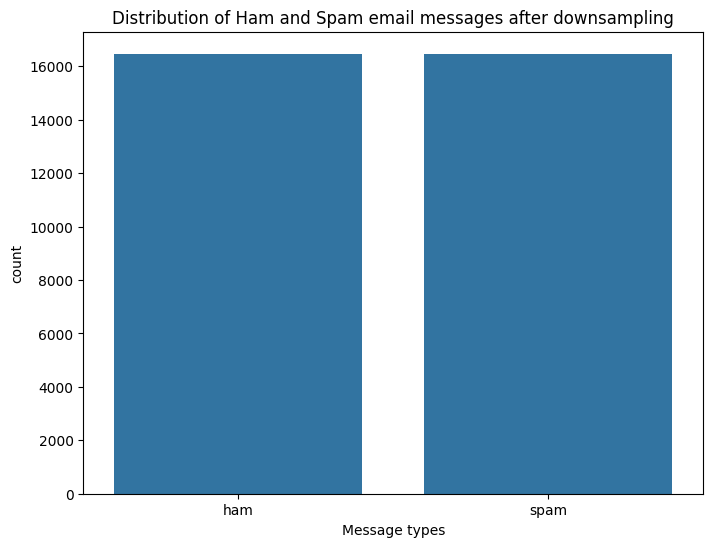

In [3]:
#balance data and plot

ham_msg = data[data.Category == 'ham']
spam_msg = data[data.Category == 'spam']
spam_msg = spam_msg.sample(n=len(ham_msg), random_state=42)

data = ham_msg.append(spam_msg).reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Category')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [4]:
# Function to remove stopwords
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []
    
    for word in str(text).split():
        word = word.lower()
        
        if word not in stop_words:
            imp_words.append(word)
            
    output = " ".join(imp_words)
    
    return output

data['Message'] = data['Message'].apply(lambda text: remove_stopwords(text))


In [5]:
# Function to remove punctuations
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

data['Message'] = data['Message'].apply(lambda x: remove_punctuations(x))

print(data)

                                                 Message Category
0                                                    nan      ham
1      gary  production high island larger block  1  ...      ham
2                    calpine daily gas nomination 1  doc      ham
3      fyi  see note  already done  stella           ...      ham
4      fyi                        forwarded lauri all...      ham
...                                                  ...      ...
32931  need mlcrosoft software might need  windows xp...     spam
32932  sex revival low  priced viagra  summertime  li...     spam
32933   col  michael bundu  democratic republic congo...     spam
32934  dear bruceg  em  ca  may promote business  1  ...     spam
32935  merhaba  multi  gsm kartlarla tek telefonda  a...     spam

[32936 rows x 2 columns]


In [6]:
# Function to plot word cloud
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['Message'])
    plt.figure(figsize=(7, 7))
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400, collocations=False).generate(email_corpus)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

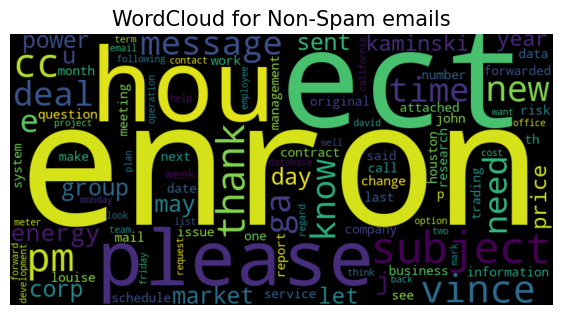

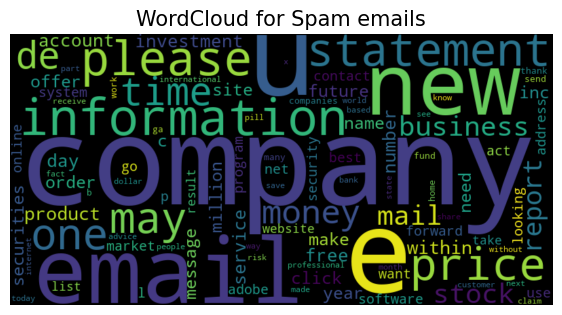

In [7]:
plot_word_cloud(data[data['Category'] == 'ham'], typ='Non-Spam')
plot_word_cloud(data[data['Category'] == 'spam'], typ='Spam')

In [8]:
# Splitting data into train and test sets
train_X, test_X, train_Y, test_Y = train_test_split(data['Message'], data['Category'], test_size=0.2, random_state=42)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

In [9]:
len(tokenizer.word_index)

132276

In [10]:
max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [11]:
# Encoding the labels
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(train_Y)
test_Y = label_encoder.transform(test_Y)

In [12]:
# Building the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=0.001)
history = model.fit(train_sequences, train_Y, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.7977 - loss: 0.3961 - val_accuracy: 0.9562 - val_loss: 0.1784 - learning_rate: 0.0010
Epoch 2/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.9259 - loss: 0.2379 - val_accuracy: 0.6395 - val_loss: 0.5871 - learning_rate: 0.0010
Epoch 3/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6619 - loss: 0.5682 - val_accuracy: 0.7011 - val_loss: 0.4956 - learning_rate: 0.0010
Epoch 4/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.8442 - loss: 0.3259 - val_accuracy: 0.9454 - val_loss: 0.1207 - learning_rate: 0.0010
Epoch 5/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.9862 - loss: 0.0482 - val_accuracy: 0.9848 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 6/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.9952 - loss: 0.0185 - val_accuracy: 0.9858 - val_loss: 0.0530 - learning_rate: 0.0010
Epoch 7/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.9965 - l

In [14]:
# Evaluating the model
loss, accuracy = model.evaluate(test_sequences, test_Y)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9826 - loss: 0.0785
Test Accuracy: 98.54%


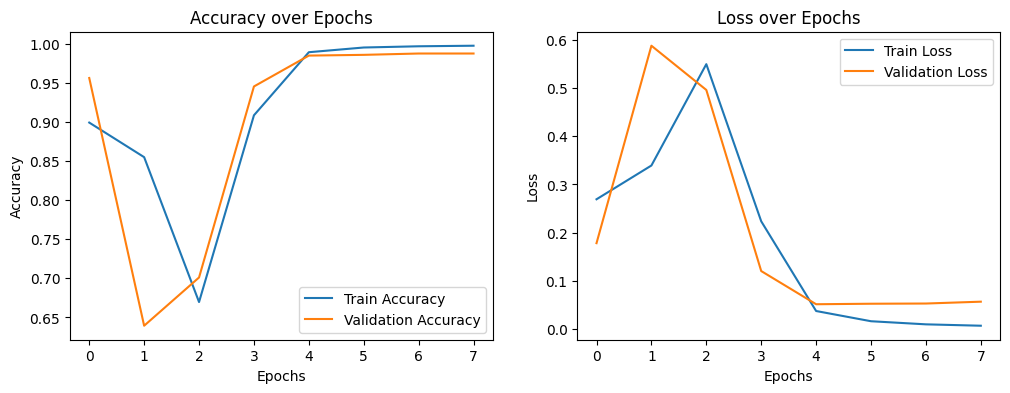

In [15]:
# Plotting the accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
# Summarize the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │       4,232,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,709,733 (48.48 MB)

 Trainable params: 4,236,577 (16.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,473,156 (32.32 MB)

In [ ]:
# Function to predict if a message is spam or ham
def predict_message(model, tokenizer, message):
    message = remove_stopwords(message)
    message = remove_punctuations(message)
    sequence = tokenizer.texts_to_sequences([message])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)
    return 'Spam' if prediction >= 0.5 else 'Ham'

# # Example of using the predict_message function
# while True:
user_input = input("Enter a message to check if it's spam or ham: ")
prediction = predict_message(model, tokenizer, user_input)
print(f'The message is predicted to be: {prediction}')
